# Project: Build a Traffic Sign Recognition Classifier

## Function Library

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import csv
import cv2
import random
import sys
import time
import readline
import tensorflow as tf
import itertools
import math
import warnings
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from tensorflow.contrib.layers import flatten
from math import ceil
from matplotlib import gridspec
from IPython.display import Markdown, display, HTML
from skimage import color
from skimage.transform import rotate, AffineTransform, warp, ProjectiveTransform
%matplotlib inline
warnings.filterwarnings("ignore")

# Print Markdown text
def printmd(string):
    display(Markdown(string))

# Obtain y or n from the user
def yn(message: str):
    while True:
        answer = input(message + ' [y/n]: ')
        if len(answer) > 0 and answer[0].lower() in ('y', 'n'):
            return answer[0].lower() == 'y'

# Trim Sign Names to a set length
def trimname(name, length):
    tname = name
    if len(name) > length:
        firsthalf = int(length/2) - 1
        secondhalf = length - firsthalf - 3
        tname = name[:firsthalf] + "..." + name[-secondhalf:]
    elif len(name) < length:
        tname = name.rjust(length)        
    return tname
        
# Open and load sign names
def OpenCSV():
    with open('signnames.csv') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',')
        signnames = []
        for row_id, row in enumerate(csv_reader):
            if row_id == 0:
                pass
            else:
                row[1]=trimname(row[1], 22)
                signnames.append(row[1])
    return signnames

# Plot a histogram of the signs
def plot_histogram(data, fname, signnames):
    plt.style.use("seaborn-dark")
    classes = pd.DataFrame()
    classes['label'] = data
    ax = classes['label'].value_counts().plot(kind='barh', figsize = (10,10))
    ax.set_facecolor('white')
    ax.set_xticklabels([])
    ax.set_yticklabels(list(map(lambda x: signnames[x], classes['label'].value_counts().index.tolist()))) 
    for i, v in enumerate(classes['label'].value_counts()):
        ax.text(v + 10, i - 0.25, "{:,}".format(v))
    plt.savefig(fname)
    plt.show()
      
# Enhance color images using CLAHE
def colorCLAHE(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    HSV_planes = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=.8,tileGridSize=(4,4))
    HSV_planes[2] = clahe.apply(HSV_planes[2])
    hsv = cv2.merge(HSV_planes)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

def plot_images(signnames, fname, X, y = None, indices = None, cols = 5):   
    if indices is None:
        indices = range(len(X))    
    rows = np.ceil(len(indices) / cols).astype('uint32')
    plt.figure(figsize = (15, rows * 2))
    plt.subplots_adjust(hspace=0.6, wspace=0.4)
    for i, index in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        if y is not None:
            plt.title("Class " + str(y[index]), fontsize=10)
        signname = signnames[y[index]]
        signname = signname.strip()
        plt.text(int(X[index].shape[0] / 2), X[index].shape[1], signname,
                verticalalignment='top', 
                horizontalalignment='center',
                color='black', fontsize=10)
        plt.xticks([])
        plt.yticks([])
        if X[index].shape[2] == 1:
            plt.imshow(X[index][:,:,0], cmap='gray')
        else:
            plt.imshow(colorCLAHE(X[index]), cmap='gray')
    plt.savefig(fname)
    plt.show()

def plot_random_samples(X, y, fname, signnames, num = 5, from_index = 0):    
    samples = np.random.randint(from_index, len(X), size=num)
    plot_images(signnames, fname, X, y, samples)    
    return samples

# Function to Calculate time since `start` and format as a string
def get_time(start = None):
    if start is None:
        return time.strftime("%H:%M:%S")
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str 

# Function to Print iteration progress
def print_progress(task, iteration, total):
    if iteration == total or iteration % 1000 == 0:
        percents = iteration / total
        print(task + " " * (25 - len(task)) + " - Progress: {:.0%}".format(percents), end = "\r", flush = True)
        
# Function to Print elapsed time
def print_elapsed(task, start):
    print(task + " " * (25 - len(task)) + " - Elapsed Time: " + get_time(start))
        
# Function to extend the data set by flipping where possible
def flip_extend(X, y, num_classes):
    start = time.time()
    task = "Appending flipped images"
# Horizontally flippable (same class)
    self_flippable_horizontally = \
        np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
# Vertically flippable (same class)
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
# Horizontally and vertically flippable (same class)
    self_flippable_both = np.array([32, 40])
# Horizontally flippable (different class)
    cross_flippable = np.array([
        [19, 20], 
        [33, 34], 
        [36, 37], 
        [38, 39],
        [20, 19], 
        [34, 33], 
        [37, 36], 
        [39, 38],   
    ])
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], \
        dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    for c in range(num_classes):
        X_extended = np.append(X_extended, X[y == c], axis = 0)
# Flip signs horizontally if appropriate...
        if c in self_flippable_horizontally:
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1], axis = 0)
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - \
            y_extended.shape[0]), c, dtype = int))     
# Flip images horizontally and place into another class in appropriate...
        if c in cross_flippable[:, 0]:
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, \
                X[y == flip_class][:, :, ::-1], axis = 0)
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - \
            y_extended.shape[0]), c, dtype = int))     
# Flip images vertically if appropriate...
        if c in self_flippable_vertically:
            X_extended = np.append(X_extended, \
                X_extended[y_extended == c][:, ::-1, :], axis = 0)
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - \
            y_extended.shape[0]), c, dtype = int))
# Flip images horizontally AND vertically if appropriate...
        if c in self_flippable_both:
            X_extended = np.append(X_extended, \
                X_extended[y_extended == c][:, ::-1, ::-1], axis = 0)
        y_extended = np.append(y_extended, \
            np.full((X_extended.shape[0] - y_extended.shape[0]), \
            c, dtype = int))
    print_elapsed(task, start) 
    return (X_extended, y_extended)

# Functions to augment training data through transformation
def augment_regen_check(X_train, y_train, class_sample_size, \
    signnames):
# Generate full training dataset
# Counts by Class
    _, class_generated = np.unique(y_train, return_counts = True)
# Samples needed by Class
    class_augment = np.subtract(class_sample_size, class_generated)
    X_train, y_train = augment_sample(X_train, y_train, class_augment, \
        class_generated, signnames)
    dump_file = path() + "full_train.p"
    pickle.dump({
        "features" : X_train,
        "labels" : y_train
        }, open(dump_file, "wb" ) )
    print(dump_file + " has been saved")
    return X_train, y_train

# Load a dataset
def load_dataset(load_file):
    load_file = path() + load_file
    print("loading " + load_file)
    if load_file[-2:] == '.p':
        with open(load_file, mode='rb') as f:
            data = pickle.load(f)
    else:
        data = np.load(load_file)
    X, y = data['features'], data['labels']  
    return X, y

def path():
    path = os.curdir + "/traffic-signs-data/"
    return path

# Augment Training Data using Transformations of Existing Samples
def augment_sample(X, y, images_needed, images_infile, signnames):
# Determine number of images to create and delete
    total_to_create = int(np.sum(images_needed[images_needed>0]))
    total_to_delete = int(-np.sum(images_needed[images_needed<0]))
    total = total_to_create + total_to_delete
    count = np.sum(images_infile)
    print("Augmenting samples by creating " + "{0:,}".format(total_to_create) + \
          " images and deleting " + "{0:,}".format(total_to_delete) + " images")
    n = 0
    nc = 0
    X_augmented = np.empty((total_to_create, X.shape[1], X.shape[2], \
                            X.shape[3]), dtype = X.dtype)
    y_augmented = np.empty(total_to_create, dtype = y.dtype)
# Augment data by class
# This utility assures the total data set is scaled proportionally
# to the original data set
    task = "Initializing images"
    for c in range(count):
        index = y[c]
        img2gen = round(images_needed[index] / images_infile[index])
        if img2gen > 0:
# Augment data by generating a transformed image
            for i in range(int(img2gen)):
                X_augmented[nc] = X[c]
                y_augmented[nc] = index
                nc += 1
                n += 1
        else:
# Flag images from original dataset for deletion
            img2gen = -images_needed[index] / images_infile[index]
            if random.random() <= img2gen:
                y[c] = -1
                img2gen = -1
                n += 1
            else:
                img2gen = 0
        images_infile[index] -= 1
        images_needed[index] -= img2gen
        print_progress(task, n, total)
    print_elapsed(task, start)
    X_augmented = img_augment(X_augmented, y_augmented)
# Copy original dataset to augmented data
# (this will also delete images from the original dataset when
# extending the data generated too many images)
    X_augmented = np.append(X_augmented, X[y>=0], axis=0)
    y_augmented = np.append(y_augmented, y[y>=0])
    return X_augmented, y_augmented

# Augment Training Data using Transformations of Existing Samples
def x_augment_sample(X, y, images_needed, images_infile, signnames):
# Determine number of images to create and delete
    total_to_create = np.sum(images_needed[images_needed>0])
    total_to_delete = -np.sum(images_needed[images_needed<0])
    total = total_to_create + total_to_delete
    count = np.sum(images_infile)
    print("Augmenting samples by creating " + "{0:,}".format(total_to_create) + \
          " images and deleting " + "{0:,}".format(total_to_delete) + " images")
    n = 0
    X_augmented = np.empty([0, X.shape[1], X.shape[2], \
                            X.shape[3]], dtype = X.dtype)
    y_augmented = np.empty([0], dtype = y.dtype)
# Augment data by class
# This utility assures the total data set is scaled proportionally
# to the original data set
    task = "Initializing images"
    for c in range(count):
        index = y[c]
        img2gen = round(images_needed[index] / images_infile[index])
        if img2gen > 0:
# Augment data by generating a transformed image
            for i in range(int(img2gen)):
                img = X[c]
                n += 1
                X_augmented = np.append(X_augmented, [img], axis=0)
                y_augmented = np.append(y_augmented, index)
        else:
# Flag images from original dataset for deletion
            img2gen = -images_needed[index] / images_infile[index]
            if random.random() <= img2gen:
                y[c] = -1
                img2gen = -1
                n += 1
            else:
                img2gen = 0
        images_infile[index] -= 1
        images_needed[index] -= img2gen
        print_progress(task, n, total)
    print_elapsed(task, start)
    X_augmented = img_augment(X_augmented, y_augmented)
# Copy original dataset to augmented data
# (this will also delete images from the original dataset when
# extending the data generated too many images)
    X_augmented = np.append(X_augmented, X[y>=0], axis=0)
    y_augmented = np.append(y_augmented, y[y>=0])
    return X_augmented, y_augmented

def img_augment(X, Y):
    X = img_brightness(X, 0.5)
    X = img_rotate(X, 0.5)
    X = img_zoom(X, 0.5)
    X = img_warp(X, 0.5)
    print()
    return X
       
# Randomly adjust brightness
def img_brightness(X, intensity=0.5, depth=.25):
    start = time.time()
    task = "Adjusting brightness"
    X = np.asarray([cv2.cvtColor(img, cv2.COLOR_BGR2HSV) for img in X])
    for i in range(X.shape[0]):
        random_bright = random.uniform(-intensity * .3, intensity * .3)
        img = X[i]
        img[:, :, 2] = img[:, :, 2] + random_bright
        img[:, :, 2][img[:, :, 2] > 255] = 255
        img[:, :, 2][img[:, :, 2] < 0] = 0
        X[i] = img
        print_progress(task, i, X.shape[0])
    print_elapsed(task, start)
    return np.asarray([cv2.cvtColor(img, cv2.COLOR_HSV2BGR) for img in X])

# Rotate by random angle
def img_rotate(X, intensity=0.5):
    start = time.time()
    task = "Rotating images"
    delta = 30. * intensity
    for i in range(X.shape[0]):   
        X[i] = rotate(X[i], random.uniform(-delta, delta), mode='edge', preserve_range=True)
        print_progress(task, i, X.shape[0])
    print_elapsed(task, start)
    return X

# Randomly zoom
def img_zoom(X, intensity=0.5):
    start = time.time()
    task = "Zooming images"
    image_size = X.shape[1]
    for i in range(X.shape[0]):
        zoom_fac = intensity * .3
        zoom_x = random.uniform(1 - zoom_fac, 1 + zoom_fac)
        zoom_y = random.uniform(1 - zoom_fac, 1 + zoom_fac)
        transform = AffineTransform(scale=(zoom_x, zoom_y))
        if random.random() < .5:
            X[i] = warp(X[i], transform, output_shape=(
                image_size, image_size), order=1, mode='edge', preserve_range=True)
        else:
            X[i] = warp(X[i], transform.inverse, output_shape=(
                image_size, image_size), order=1, mode='edge', preserve_range=True)
        print_progress(task, i, X.shape[0])
    print_elapsed(task, start)
    return np.asarray(X)

# Randomly warp
def img_warp(X, intensity=0.5):
    start = time.time()
    task = "Warping images"
    no_samples=X.shape[0]
    image_size=X.shape[1]
    no_channels=X.shape[3]
    d = image_size * 0.3 * intensity            
    for i in range(X.shape[0]):
        tl_top = random.uniform(-d, d)     # Top left corner, top margin
        tl_left = random.uniform(-d, d)    # Top left corner, left margin
        bl_bottom = random.uniform(-d, d)  # Bottom left corner, bottom margin
        bl_left = random.uniform(-d, d)    # Bottom left corner, left margin
        tr_top = random.uniform(-d, d)     # Top right corner, top margin
        tr_right =random.uniform(-d, d)   # Top right corner, right margin
        br_bottom =random.uniform(-d, d)  # Bottom right corner, bottom margin
        br_right = random.uniform(-d, d)   # Bottom right corner, right margin
        transform = ProjectiveTransform()
        transform.estimate(np.array((
                (tl_left, tl_top),
                (bl_left, image_size - bl_bottom),
                (image_size - br_right, image_size - br_bottom),
                (image_size - tr_right, tr_top)
            )), np.array((
                (0, 0),
                (0, image_size),
                (image_size, image_size),
                (image_size, 0)
            )))
        if random.random() < .5:
            X[i] = warp(X[i], transform, output_shape=(image_size, image_size), order = 1, mode = 'edge', preserve_range=True)
        else:
            X[i] = warp(X[i], transform.inverse, output_shape=(image_size, image_size), order = 1, mode = 'edge',
                        preserve_range=True)
        print_progress(task, i, X.shape[0])
    print_elapsed(task, start)  
    return np.asarray(X)

# Preprocess the data
def preprocess_dataset(X, y, num_classes, save_file):
    print()
    start = time.time()
    print("Start Time: " + get_time())
    print()
    print (save_file + " images")
    total = int(X.shape[0])
# Greyscale the data
    start_ = time.time()
    task = "Greyscaling"
    print(task + "...", end = "\r")
    X = np.dot(X[...,:3], [0.299, 0.587, 0.114])
    print_elapsed(task, start_)
# Apply Contrast limited Adaptive Histogram Equalization 
    start_ = time.time()
    task = "Applying CLAHE"
    print(task + "...", end = "\r")
    clahe = cv2.createCLAHE(clipLimit=.8, tileGridSize=(4,4))
    for i in range(X.shape[0]):
        X[i] = clahe.apply(np.uint8(X[i]))
        print_progress(task, i, X.shape[0])
    print_elapsed(task, start_)
# Apply Equalization Histograms
    task = "Equalizing image contrast"
    start_ = time.time()
    for i in range(X.shape[0]):
        X[i] = cv2.equalizeHist(np.uint8(X[i]))
        print_progress(task, i, X.shape[0])
    print_elapsed(task, start_)
# Normalize the data
    start_ = time.time()
    task = "Normalizing"
    print(task + "...", end = "\r")
    X = ((X - 128) / 128.).astype(np.float32)
# Change color dimension from RGB to Grey
    X = X.reshape(X.shape + (1,))
    print_elapsed(task, start_)
# Save preprocessed file
    start_ = time.time()
    task = "Saving"
    print(task + "...", end = "\r")
    save_file = path() + save_file
    np.savez(save_file, features=X, labels=y)
    print_elapsed(task, start_)
# Display Shape of the preprocessed traffic sign images
    image_shape = X[0].shape
    print("Preprocessed image data shape =", image_shape)
    print()
    print("End Time: " + get_time())
    print("Elapsed Time: " + get_time(start))
    return X, y

# Evaluate Models for a given dataset
def evaluate(X_data, y_data, BATCH_SIZE):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], \
            y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, \
            feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Train Models in numerical order
def getModel(z, models, x):
    for key, value in models.items():
        if key[:1] == str(z + 1):
            logits = value
            return logits
    return "error"

def getModelInfo(z, models):
    if z < 0:
        return len(models)
    else:
        for key, value in models.items():
            if key[:1] == str(z + 1):
                return key
        return "error"

# Helper functions for Models
def conv2d(x, kernel, input_depth, output_depth, stride=1, padding='SAME', \
    mu=0, sigma=0.1):
    shape = (kernel, kernel, input_depth, output_depth)
    W = tf.Variable(tf.truncated_normal(shape=shape, mean=mu, stddev=sigma))
    b = tf.Variable(tf.zeros(output_depth))
    conv = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    conv = tf.nn.bias_add(conv, b)
    return conv


def fully(x, input_size, output_size, mu=0, sigma=0.1):
    W = tf.Variable(tf.truncated_normal(shape=(input_size, output_size), \
        mean=mu, stddev=sigma))
    b = tf.Variable(tf.zeros(output_size))
    fc = tf.matmul(x, W)
    fc = tf.add(fc, b)
    return fc


def max_pool(x, size, padding='VALID'):
    return tf.nn.max_pool(x, ksize=[1, size, size, 1], \
        strides=[1, size, size, 1], padding=padding)

# VGGNet model was adapted from:
### https://github.com/mohamedameen93/German-Traffic-Sign-Classification-Using-TensorFlow

def VGG(x):
    
# Layer 1 (Convolutional): Input = 32x32x1. Output = 32x32x32
# 3x3 convolution with Relu activation
    conv1 = conv2d(x, 3, 1, 32)
    conv1 = tf.nn.relu(conv1)
    
# Layer 2 (Convolutional): Input = 32x32x32. Output = 16x16x32.
# 3x3 convolution with Relu activiation, then 2x2 max pooling
    conv2 = conv2d(conv1, 3, 32, 32)    
    conv2 = tf.nn.relu(conv2)
    conv2 = max_pool(conv2, 2)
    #conv2 = tf.nn.dropout(conv2, keep_prob)
    
# Layer 3 (Convolutional): Input = 16x16x32. Output = 16x16x64
# 3x3 convolution with Relu activation
    conv3 = conv2d(conv2, 3, 32, 64)    
    conv3 = tf.nn.relu(conv3)

# Layer 4 (Convolutional): Input = 16x16x64. Output = 8x8x64.
# 3x3 convolution with Relu activiation, then 2x2 max pooling
    conv4 = conv2d(conv3, 3, 64, 64)
    conv4 = tf.nn.relu(conv4)
    conv4 = max_pool(conv4, 2)
    #conv4 = tf.nn.dropout(conv4, keep_prob)
    
# Layer 5 (Convolutional): Input = 8x8x64. Output = 8x8x128.
# 3x3 convolution with Relu activation
    conv5 = conv2d(conv4, 3, 64, 128)    
    conv5 = tf.nn.relu(conv5)
    
# Layer 6 (Convolutional): Input = 8x8x128. Output = 4x4x128.
# 3x3 convolution with Relu activiation, then 2x2 max pooling
    conv6 = conv2d(conv5, 3, 128, 128)
    conv6 = tf.nn.relu(conv6)
    conv6 = max_pool(conv6, 2)
    #conv6 = tf.nn.dropout(conv6, keep_prob)

# Flatten. Input = 4x4x128. Output = 2048.
    flattened = flatten(conv6)
    
# Layer 7 (Fully Connected): Input = 2048. Output = 128.
# Dropout to reduce variance
    fully7 = fully(flattened, 2048, 128)
    fully7 = tf.nn.relu(fully7)
    fully7 = tf.nn.dropout(fully7, keep_prob)

# Layer 8 (Fully Connected): Input = 128. Output = 128.
    fully8 = fully(fully7, 128, 128)
    fully8 = tf.nn.relu(fully8)
    fully8 = tf.nn.dropout(fully8, keep_prob)

# Layer 9 (Fully Connected): Input = 128. Output = 43.
    logits = fully(fully8, 128, 43)
    
    return logits

def plot_confusion_matrix(cm, fname, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(round(cm[i, j] * 100)),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh or round(cm[i, j] * 100) == 0 \
                 else "black")

    plt.tight_layout()
    plt.ylabel('Actual Sign Name')
    plt.xlabel('Predicted Sign Name')
    plt.savefig(fname)
    plt.show()
    
def getFileName(name):
    return "media/" + name.replace(" ", "_") + ".png"

def init():
    model = "VGG"
    model_path = os.curdir + "/model-data/" + model
    model_file = model_path + "/" + model + ".cktp"
    _, y_train = load_dataset("valid.p")
    n_classes = len(np.unique(y_train))
    signnames = OpenCSV()
    return n_classes, signnames, model_path, model_file

print("All functions are loaded")

All functions are loaded


## Step 1: Dataset Summary & Exploration

loading ./traffic-signs-data/train.p
loading ./traffic-signs-data/valid.p
loading ./traffic-signs-data/test.p
loading ./traffic-signs-data/valid.p


#### Exploratory Visualization

Training Sample Histogram:


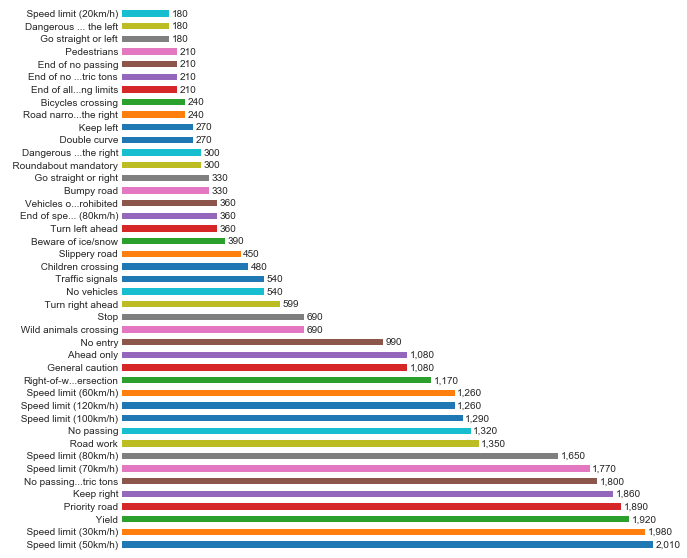

Start Time: 09:33:54

Appending flipped images  - Elapsed Time: 00:00:04
Augmenting samples by creating 262,772 images and deleting 60 images
Initializing images       - Elapsed Time: 00:00:05
Adjusting brightness      - Elapsed Time: 00:00:07
Rotating images           - Elapsed Time: 00:01:08
Zooming images            - Elapsed Time: 00:01:33
Warping images            - Elapsed Time: 00:02:26

./traffic-signs-data/full_train.p has been saved

End Time: 09:39:23
Elapsed Time: 00:05:28

Random Augmented Training Samples:


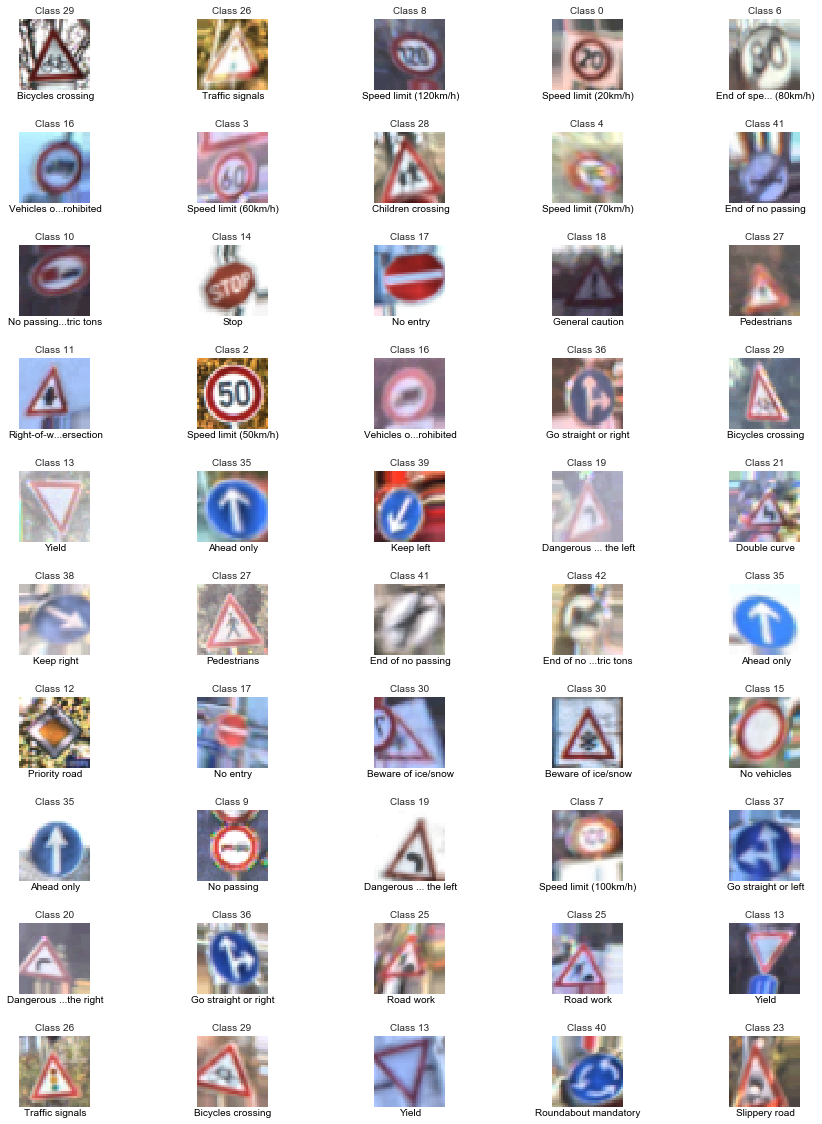

Augmented Training Sample Histogram:


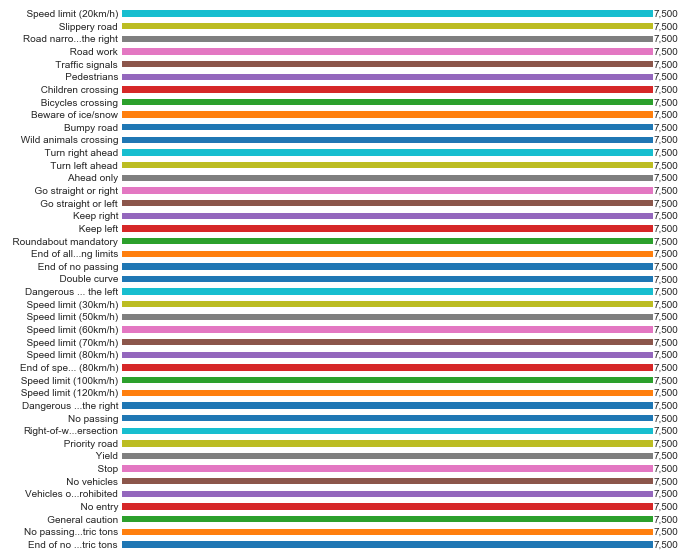

#### Readme.md

#### Dataset Summary

Basic Summary of the dataset:

- Number of training examples = 34,799
- Number of testing examples = 12,630
- Number of validation examples = 4,410
- Image data shape =  (32, 32, 3)
- Number of classes =  43

#### Exploratory Visualization

Training Sample Histogram:

![png](media/Training_Sample_Histogram.png)

#### Augmented Training Data
The sample data was increased to 322,500 images using rotation, translation, shearing, warping and flipping:

Random Augmented Training Samples:

![png](media/Random_Augmented_Training_Samples.png)

Augmented Training Sample Histogram:

![png](media/Augmented_Training_Sample_Histogram.png)



In [2]:
#Load data into arrays
X_train, y_train = load_dataset("train.p")
X_valid, y_valid = load_dataset("valid.p")
X_test, y_test = load_dataset("test.p")

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas
# Number of training examples
n_train = X_train.shape[0]
# Number of testing examples
n_test = X_test.shape[0]
# Number of validation examples.
n_validation = X_valid.shape[0]
# Shape of a traffic sign image
image_shape = X_train[0].shape
# Get number of classes and sign names
n_classes, signnames, _, _ = init()

# Desired Size of Sample Training Data 
sample_multiplier = 0     #Increase training sample size by this factor * or *
sample_size = 7500        #Fix training sample size to this number (choose one)
# This size will be reached through flipping and/or transforming training data
if sample_multiplier != 0:
    _, class_sample_size = np.multiply(np.unique(y_train, return_counts = True), sample_multiplier)
else:
    class_sample_size = np.add(np.zeros(n_classes), sample_size)
# Exploratory visualization of the original training dataset
namex = "Training Sample Histogram"
fnamex = getFileName(namex)
printmd("#### Exploratory Visualization")
print(namex + ":")
_ = plot_histogram(y_train, fnamex, signnames)

start = time.time()
print("Start Time: " + get_time())
print()
# Extend Training samples by flipping
X_train, y_train = flip_extend(X_train, y_train, n_classes)
n_extended = X_train.shape[0]

# Augment Training samples through transformation
X_train, y_train = augment_regen_check(X_train, y_train, \
    class_sample_size, signnames)
n_augmented = X_train.shape[0]
print()
print("End Time: " + get_time())
print("Elapsed Time: " + get_time(start))

# Exploratory visualization of the augmented, flipped and original dataset
names = "Random Augmented Training Samples"
fnames = getFileName(names)
print()
print(names+":")
_ = plot_random_samples(X_train, y_train, fnames, signnames, 50)
namea = "Augmented Training Sample Histogram"
fnamea = getFileName(namea)
print(namea + ":")
_ = plot_histogram(y_train, fnamea, signnames)

printmd("#### Readme.md")
print("#### Dataset Summary")
print()
print("Basic Summary of the dataset:")
print()
print("- Number of training examples = {:,}".format(n_train))
print("- Number of testing examples = {:,}".format(n_test))
print("- Number of validation examples = {:,}".format(n_validation))
print("- Image data shape = ", image_shape)
print("- Number of classes = ", n_classes)
print()
print("#### Exploratory Visualization")
print()
print(namex + ":")
print()
print("![png](" + fnamex + ")")
print()
print("#### Augmented Training Data")
if n_augmented > n_train:
    print("The sample data was increased to {:,} images using rotation, " \
          "translation, shearing, warping and flipping:".format(n_augmented))
print()
print(names + ":")
print()
print("![png](" + fnames + ")")
print()
print(namea + ":")
print()
print("![png](" + fnamea + ")")
print()

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

loading ./traffic-signs-data/valid.p
loading ./traffic-signs-data/full_train.p
Number of training examples: 322,500

Start Time: 15:23:08

preprocessed_train images
Greyscaling               - Elapsed Time: 00:01:11
Applying CLAHE            - Elapsed Time: 00:00:09
Equalizing image contrast - Elapsed Time: 00:00:02
Normalizing               - Elapsed Time: 00:00:17
Saving                    - Elapsed Time: 00:00:22
Preprocessed image data shape = (32, 32, 1)

End Time: 15:25:13
Elapsed Time: 00:02:04



#### Random Preprocessed Training Samples

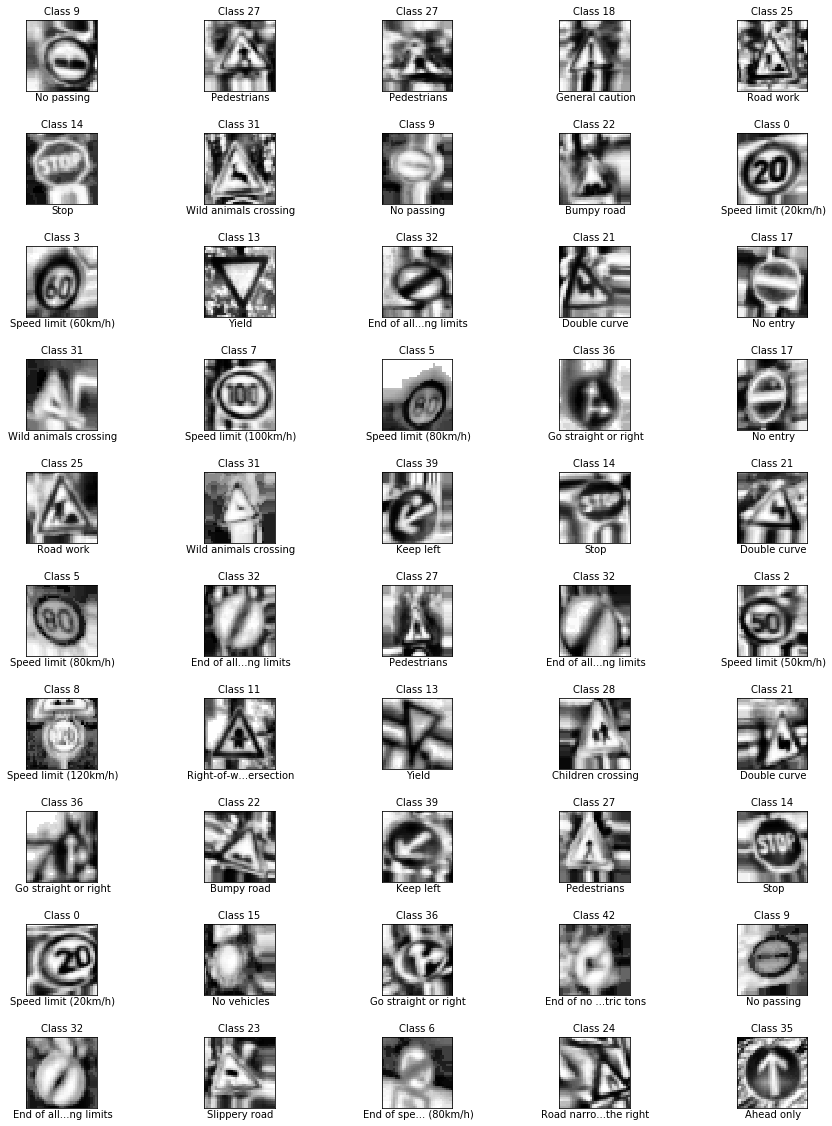

#### Readme.md

Random Preprocessed Training Samples:

![png](media/Random_Preprocessed_Training_Samples.png)

loading ./traffic-signs-data/valid.p

Start Time: 15:25:20

preprocessed_valid images
Greyscaling               - Elapsed Time: 00:00:00
Applying CLAHE            - Elapsed Time: 00:00:00
Equalizing image contrast - Elapsed Time: 00:00:00
Normalizing               - Elapsed Time: 00:00:00
Saving                    - Elapsed Time: 00:00:00
Preprocessed image data shape = (32, 32, 1)

End Time: 15:25:21
Elapsed Time: 00:00:00


In [2]:
# load the full training dataset and the sign names
n_classes, signnames, _, _ = init()
X_train, y_train = load_dataset("full_train.p")
print("Number of training examples: {:,}".format(X_train.shape[0]))
# preprocess the training data
X_train, y_train = preprocess_dataset(X_train, y_train, \
    n_classes, "preprocessed_train")
print()
name = "Random Preprocessed Training Samples"
fname = getFileName(name)
printmd("#### " + name)
_ = plot_random_samples(X_train, y_train , fname, signnames, 50)
printmd("#### Readme.md")
print(name + ":")
print()
print("![png](" + fname + ")")
print()
# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train)
# Open validation file and load data
X_valid, y_valid = load_dataset("valid.p")
# preprocess the validation data
X_valid, y_valid = preprocess_dataset(X_valid, y_valid, \
    n_classes, "preprocessed_valid")

### Load the Model Architecture

In [4]:
printmd("#### Loading the Model Architecture:")
# Set training parameters
EPOCHS = 100
BATCH_SIZE = 256
# Features and labels
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
_, y_train = load_dataset("valid.p")
n_train = y_train.size
n_classes, _, _, _ = init()
one_hot_y = tf.one_hot(y, n_classes)
# Exponential decaying learning rate
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
    learning_rate=0.0005,
    global_step=global_step,
    decay_steps=ceil(n_train / BATCH_SIZE),  # Decay every epoch
    decay_rate=0.95,
    staircase=True)
# Training pipeline
logits = VGG(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits( \
    labels = one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

#### Loading the Model Architecture:

loading ./traffic-signs-data/valid.p
loading ./traffic-signs-data/valid.p


### Train the Model

In [34]:
printmd("#### Training the Model:")
_, _, model_path, model_file = init()
patience = 5
name = "Training Results"
X_train, y_train = load_dataset("preprocessed_train.npz")
X_valid, y_valid = load_dataset("preprocessed_valid.npz")
num_examples = len(X_train)
start = time.time()
last = start
print()
print("Start Time: " + get_time())
best_epoch = 0
best_val_acc = 0
md_val_acc = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    printmd("#### " + name + ":")
    try:
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, \
                    feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            validation_accuracy = evaluate(X_valid, y_valid, BATCH_SIZE)
            md_val_acc.append(validation_accuracy)
            status = "...EPOCH {: >2d}: Validation Accuracy = ".format(i + 1) +  \
                "{:6.2%}".format(validation_accuracy) + ": Elapsed Time is " + get_time(last)
            last = time.time()
            if validation_accuracy > best_val_acc:
                best_epoch, best_val_acc = i, validation_accuracy
                if not os.path.exists(model_path):
                    if not os.path.exists(os.curdir + "/model-data"):
                        os.mkdir(os.curdir + "/model-data")
                    os.mkdir(model_path)
                saver.save(sess, '{}'.format(model_file))
                status += " (" + model_file + " saved)"
            print(status)
            if i == EPOCHS - 1 or \
                (i - best_epoch == patience and EPOCHS >= 10):
                print()
                if i == EPOCHS - 1:
                    print('Stopping after {} EPOCHS'.format(EPOCHS))
                else:
                    print('Stopping after {} '.format(patience) + \
                        'EPOCHS without improvement')
                break
    except KeyboardInterrupt:
        print("Execution Interrupted")
        pass
print("End Time: " + get_time())
print("Elapsed Time: " + get_time(start))
printmd("#### Readme.md")
print(name + ":")
print()
print("| EPOCH | Validation<br>Accuracy</br>|")
print("| :---: | :---: |")
iprnt = True
for i in range(len(md_val_acc)):
    istr = str(i + 1)
    if iprnt == True: print("| " + istr +  " | {:.2%} |".format(md_val_acc[i]))
    if md_val_acc[i] == max(md_val_acc): iprnt = False
print()

#### Training the Model:

loading ./traffic-signs-data/valid.p
loading ./traffic-signs-data/preprocessed_train.npz
loading ./traffic-signs-data/preprocessed_valid.npz

Start Time: 12:10:17


#### Training Results:

...EPOCH  1: Validation Accuracy = 76.51%: Elapsed Time is 00:39:27 (./model-data/VGG/VGG.cktp saved)
...EPOCH  2: Validation Accuracy = 96.71%: Elapsed Time is 00:39:55 (./model-data/VGG/VGG.cktp saved)
...EPOCH  3: Validation Accuracy = 98.48%: Elapsed Time is 00:39:27 (./model-data/VGG/VGG.cktp saved)
...EPOCH  4: Validation Accuracy = 99.00%: Elapsed Time is 00:39:20 (./model-data/VGG/VGG.cktp saved)
...EPOCH  5: Validation Accuracy = 99.16%: Elapsed Time is 00:39:24 (./model-data/VGG/VGG.cktp saved)
...EPOCH  6: Validation Accuracy = 99.34%: Elapsed Time is 00:39:50 (./model-data/VGG/VGG.cktp saved)
...EPOCH  7: Validation Accuracy = 99.46%: Elapsed Time is 00:39:44 (./model-data/VGG/VGG.cktp saved)
...EPOCH  8: Validation Accuracy = 99.32%: Elapsed Time is 00:39:38
...EPOCH  9: Validation Accuracy = 99.39%: Elapsed Time is 00:39:37
...EPOCH 10: Validation Accuracy = 99.55%: Elapsed Time is 00:40:06 (./model-data/VGG/VGG.cktp saved)
...EPOCH 11: Validation Accuracy = 99.61%: Elaps

#### Readme.md

Training Results:

| EPOCH | Validation<br>Accuracy</br>|
| :---: | :---: |
| 1 | 76.51% |
| 2 | 96.71% |
| 3 | 98.48% |
| 4 | 99.00% |
| 5 | 99.16% |
| 6 | 99.34% |
| 7 | 99.46% |
| 8 | 99.32% |
| 9 | 99.39% |
| 10 | 99.55% |
| 11 | 99.61% |
| 12 | 99.27% |
| 13 | 99.46% |
| 14 | 99.39% |
| 15 | 99.64% |



### Analyze Errors

loading ./traffic-signs-data/valid.p
loading ./traffic-signs-data/preprocessed_train.npz
loading ./traffic-signs-data/test.p

Start Time: 01:39:42

preprocessed_test images
Greyscaling               - Elapsed Time: 00:00:00
Applying CLAHE            - Elapsed Time: 00:00:00
Equalizing image contrast - Elapsed Time: 00:00:01
Normalizing               - Elapsed Time: 00:00:00
Saving                    - Elapsed Time: 00:00:00
Preprocessed image data shape = (32, 32, 1)

End Time: 01:39:44
Elapsed Time: 00:00:01



#### Confusion Matrix:

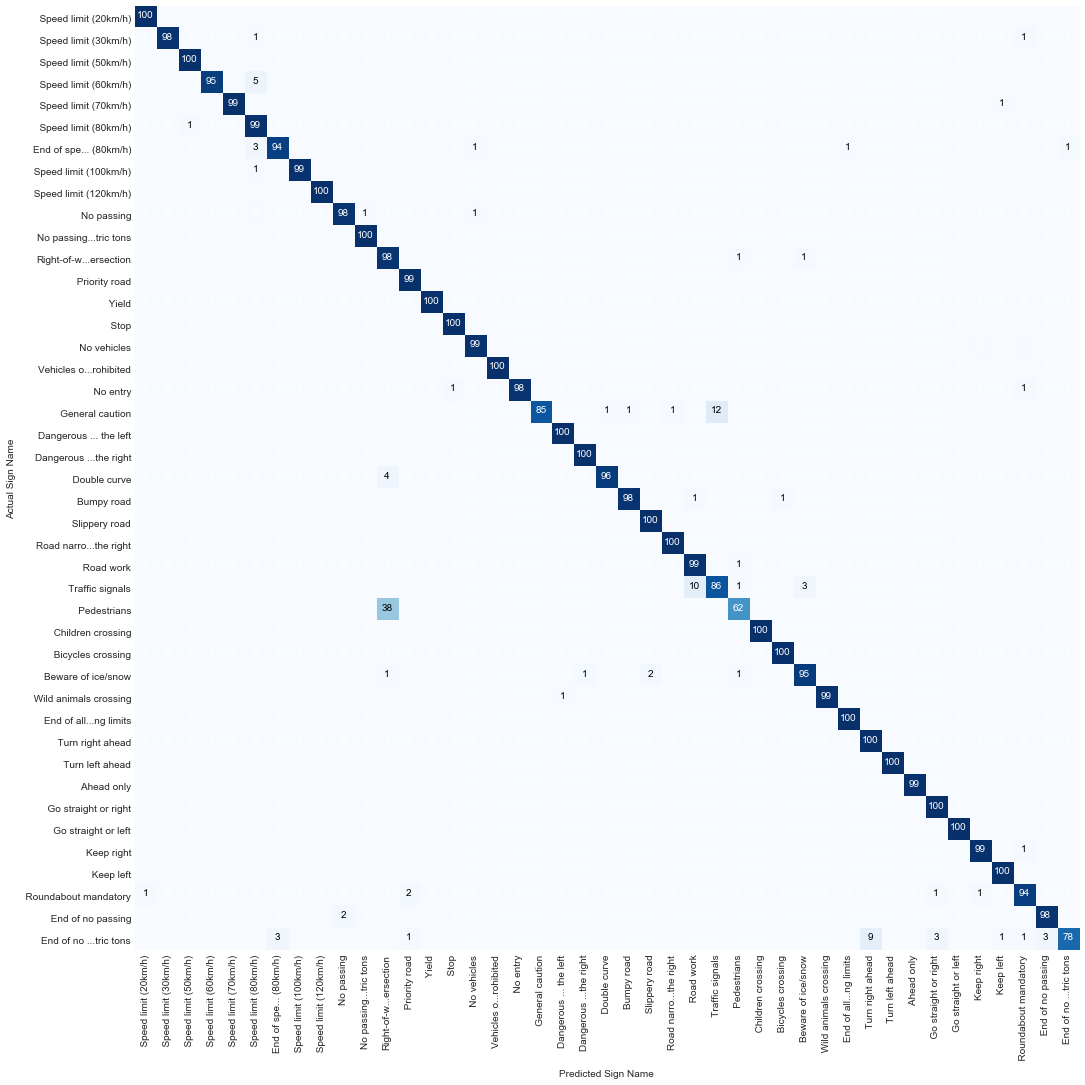

Confusion Matrix          - Elapsed Time: 00:01:11


#### Readme.md

#### Error Analysis

- Test Data Accuracy: 97.933%
- Top-3 test accuracy: 99.311%

Confusion Matrix:

![png](media/Confusion_Matrix.png)


In [35]:
# Compute confusion matrix
n_classes, signnames, model_path, _ = init()
X_train, y_train = load_dataset("preprocessed_train.npz")
task = "Confusion Matrix"
fname = getFileName(task)
X_test, y_test = load_dataset("test.p")
X_test, y_test = preprocess_dataset(X_test, y_test, \
    n_classes, "preprocessed_test")
print()
start = time.time()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(model_path))
    t_accuracy = evaluate(X_test, y_test, BATCH_SIZE) * 100
    softmax = tf.nn.softmax(logits)
    y_pred = None
    for offset in range(0, len(X_test), BATCH_SIZE):
        batch_x, batch_y = X_test[offset:offset + BATCH_SIZE], \
            y_test[offset:offset + BATCH_SIZE]
        top_softmax = sess.run(tf.nn.top_k(softmax, k=3), \
            feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        if y_pred is None:
            y_pred = top_softmax[1]
        else:
            y_pred = np.concatenate([y_pred, top_softmax[1]])
    correct = np.sum([1 for y_pred, actual in zip(y_pred, y_test) \
        if actual in y_pred])
cnf_matrix = confusion_matrix(y_test, y_pred[:, 0])
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
printmd("#### " + task + ":")
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, fname, signnames, True)
print_elapsed(task, start)
printmd("#### Readme.md")
print("#### Error Analysis")
print()
print('- Test Data Accuracy: {:.3f}%'.format(t_accuracy))
print('- Top-3 test accuracy: {:.3f}%'.format(100 * correct / len(y_test)))
print()
print(task + ":")
print()
print("![png](" + fname + ")")

## Step 3: Test a Model on New Images

### Load and Output the Images

loading ./traffic-signs-data/valid.p


#### New Images:

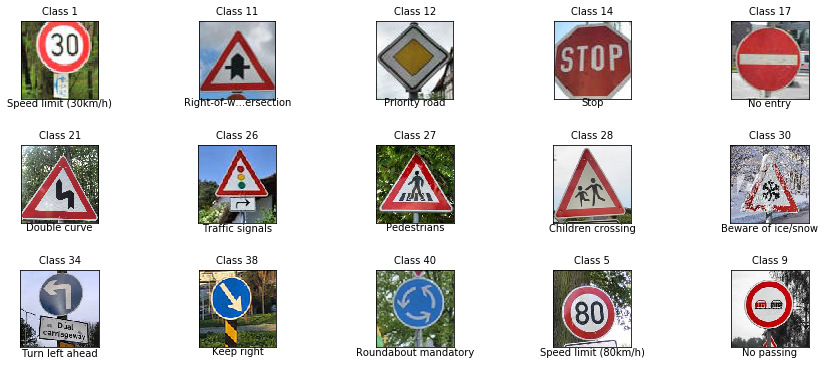

### Predict the Sign Type for Each Image and Analyze Performance


Start Time: 10:59:52

preprocessed_new images
Greyscaling               - Elapsed Time: 00:00:00
Applying CLAHE            - Elapsed Time: 00:00:00
Equalizing image contrast - Elapsed Time: 00:00:00
Normalizing               - Elapsed Time: 00:00:00
Saving                    - Elapsed Time: 00:00:00
Preprocessed image data shape = (32, 32, 1)

End Time: 10:59:53
Elapsed Time: 00:00:00
Finished preprocessing additional pictures.

Image:1, Actual:   Speed limit (30km/h), Prediction:   Speed limit (30km/h).
Image:2, Actual: Right-of-w...ersection, Prediction: Right-of-w...ersection.
Image:3, Actual:          Priority road, Prediction:          Priority road.
Image:4, Actual:                   Stop, Prediction:                   Stop.
Image:5, Actual:               No entry, Prediction:               No entry.
Image:6, Actual:           Double curve, Prediction:           Double curve.
Image:7, Actual:        Traffic signals, Prediction:        Traffic signals.
Image:8, Actual:           

### Display Top 5 Softmax Probabilities For Each New Image

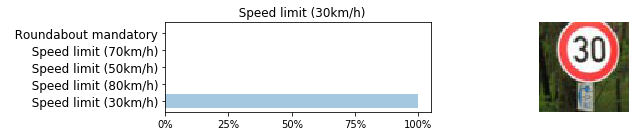

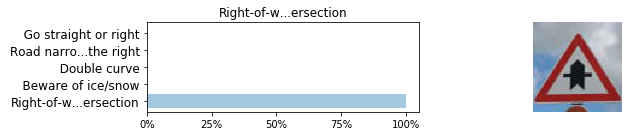

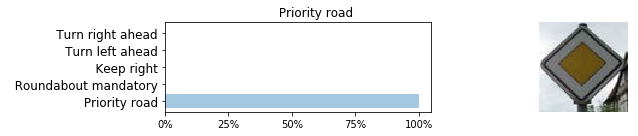

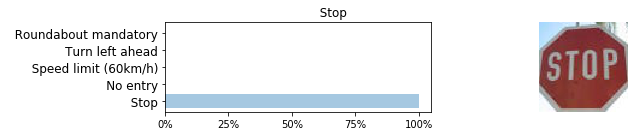

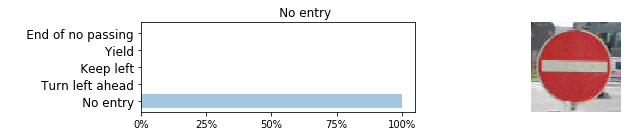

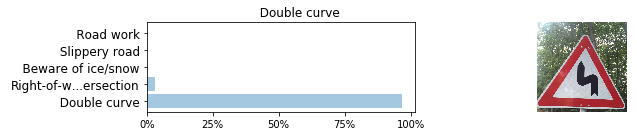

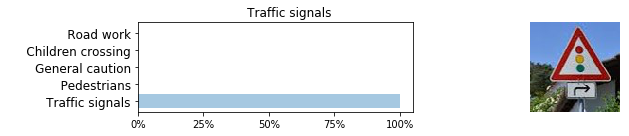

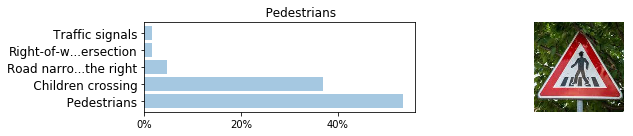

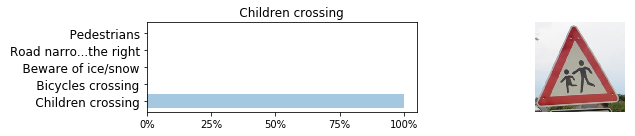

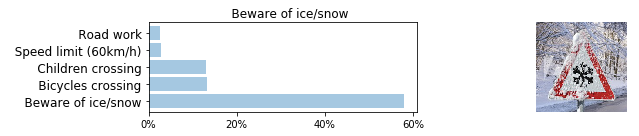

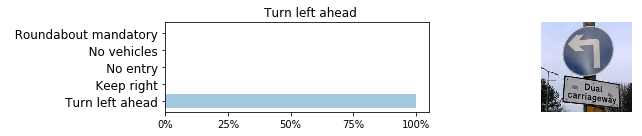

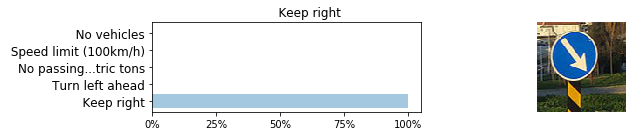

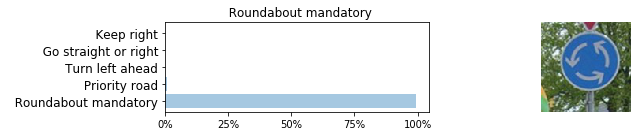

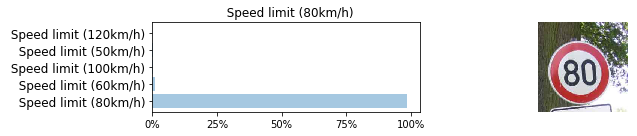

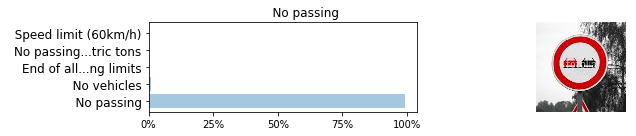

#### Readme.md

New Images:

![png](media/New_Images.png)

#### Performance on Test Images

| Image | Actual | Predicted |
| :---: | --- | --- |
| 1 |   Speed limit (30km/h) |    Speed limit (30km/h) |
| 2 | Right-of-w...ersection |  Right-of-w...ersection |
| 3 |          Priority road |           Priority road |
| 4 |                   Stop |                    Stop |
| 5 |               No entry |                No entry |
| 6 |           Double curve |            Double curve |
| 7 |        Traffic signals |         Traffic signals |
| 8 |            Pedestrians |             Pedestrians |
| 9 |      Children crossing |       Children crossing |
| 10 |     Beware of ice/snow |      Beware of ice/snow |
| 11 |        Turn left ahead |         Turn left ahead |
| 12 |             Keep right |              Keep right |
| 13 |   Roundabout mandatory |    Roundabout mandatory |
| 14 |   Speed limit (80km/h) |    Speed limit (80km/h) |
| 15 |             No passing |              No passing |

Accuracy 

In [58]:
printmd("### Load and Output the Images")
n_classes, signnames, model_path, _ = init()
saver = tf.train.Saver()
namen = "New Images"
printmd("#### " + namen + ":")
fnamen = getFileName(namen)
test_images_dir = os.curdir + "/New Traffic Signs/"
test_images = os.listdir(test_images_dir)
# Make into numpy array for processing
X_plot = []
X_new = []
y_new = []
for i in range(len(test_images)):
    img = cv2.imread(test_images_dir + test_images[i])
    X_plot.append(img[:, :, ::-1])
    y_new.append(int(test_images[i].split('.')[0]))
    X_new.append(cv2.resize(X_plot[-1], (32,32)))
plot_images(signnames, fnamen, X_plot, y_new)
printmd("### Predict the Sign Type for Each Image and Analyze Performance")
X_new = np.array(X_new)
y_new = np.array(y_new)
# Preprocess the data
X_new, y_new = preprocess_dataset(X_new, y_new, \
    n_classes, "preprocessed_new")
print('Finished preprocessing additional pictures.')
prediction = tf.nn.softmax(logits)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(model_path))
    X_pred = sess.run(prediction, feed_dict={x: X_new, keep_prob : 1.0})
    X_top, index = sess.run(tf.nn.top_k(X_pred, k=5, sorted=True))
print()
correct_count = 0
for i in range(X_new.shape[0]):
    y_pred = np.argmax(X_pred[i])
    print('Image:' + str(i + 1) + ', Actual:', signnames[y_new[i]] + ', Prediction:', signnames[y_pred] + '.')
    if y_pred == y_new[i]: correct_count += 1
pct_accurate = correct_count / X_new.shape[0] * 100
print()        
print("Accuracy for these " + str(X_new.shape[0])  + " images is " + str(pct_accurate) + "%")
### Visualize the softmax probabilities
name = "Softmax"
with tf.Session() as sess:
# Restore variables from disk.
    saver.restore(sess, tf.train.latest_checkpoint(model_path))
    print("Model restored.")
# Display softmax probabilities
printmd("### Display Top 5 Softmax Probabilities For Each New Image") 
for i in range(len(X_top)): 
    fig = plt.figure(figsize = (12, 2)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
    ax0 = plt.subplot(gs[0])
    ax0.barh(range(len(X_top[i])), X_top[i] * 100, align='center', alpha=0.4)
    ax0.set_title(signnames[y_new[i]], fontsize=12)
    plt.locator_params(axis='x', nbins=5)
    fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
    xticks = mtick.FormatStrFormatter(fmt)
    ax0.xaxis.set_major_formatter(xticks)
    labelsy = []
    y_pos = range(len(X_top[i]))
    for j in index[i]:
        labelsy.append(signnames[j])
    plt.yticks(y_pos, labelsy, fontsize=12)
    ax1 = plt.subplot(gs[1])
    image = X_plot[i]
    ax1.imshow(image)
    ax1.axis('off')
    plt.tight_layout()
    plt.grid()
    fname = getFileName(name + str(i + 1))
    plt.savefig(fname)
plt.show()
printmd("#### Readme.md")
print(namen +":")
print()
print("![png](" + fnamen + ")")
print()
print("#### Performance on Test Images")
print()
print("| Image | Actual | Predicted |")
print("| :---: | --- | --- |")
correct_count = 0
for i in range(X_new.shape[0]):
    y_pred = np.argmax(X_pred[i])
    print('| ' + str(i + 1) + ' | ' + signnames[y_new[i]] + ' | ', signnames[y_pred] + ' |')
    if y_pred == y_new[i]: correct_count += 1
pct_accurate = correct_count / X_new.shape[0] * 100
print()        
print("Accuracy for these " + str(X_new.shape[0])  + " images is " + \
      str(pct_accurate) + "%")
print()
print("#### Model Certainty - Softmax Probabilities")
for i in range(len(X_top)):
    print()
    fname = getFileName(name + str(i + 1))
    print("![png](" + fname + ")")   